## Why Spatial Analysis?

When applying clustering algorithms for events where we cover the spatial characteristics, we need to factor into account Toblers Law which states, "Everything is related to everything else, but near things are more related than distant things".

For clustering algorithms,all observations need to be independent of each other. But due to the spatial nature of data, we need to remove the effect of spatial lag of the data to make the observations independent of each other and perform clustering.

In [1]:
import pandas as pd
import urllib
import geopandas as gpd

In [2]:
crime_url = 'https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv?accessType=DOWNLOAD'
urllib.request.urlretrieve(crime_url, "crimes.csv")

('crimes.csv', <http.client.HTTPMessage at 0x7fa31b590320>)

In [3]:
crimes_df = pd.read_csv('crimes.csv')

In [4]:
crimes_df['yearoc'] = crimes_df['CMPLNT_FR_DT'].str[-4:]
crimes_df['yearoc'] = crimes_df['yearoc'].astype(int)

crimes_post2006 = crimes_df[crimes_df['yearoc'] >= 2006]

crimes_post2006['crime_date'] = pd.to_datetime(crimes_post2006['CMPLNT_FR_DT'] + ' ' + crimes_post2006['CMPLNT_FR_TM'], infer_datetime_format=True)


#group number of crimes by offense type at precinct level at date and hour:
crimes_post2006['hour'] = crimes_post2006['crime_date'].dt.hour
crimes_post2006['date_crime'] = crimes_post2006['crime_date'].dt.date


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [5]:
nypd_juris_shp = 'https://data.cityofnewyork.us/api/geospatial/78dh-3ptz?method=export&format=Shapefile'
urllib.request.urlretrieve(nypd_juris_shp, "nypd_juris_shp.zip")
!unzip nypd_juris_shp.zip

Archive:  nypd_juris_shp.zip
  inflating: geo_export_c4a19737-82d1-4433-8977-8778832716d0.dbf  
  inflating: geo_export_c4a19737-82d1-4433-8977-8778832716d0.shp  
  inflating: geo_export_c4a19737-82d1-4433-8977-8778832716d0.shx  
  inflating: geo_export_c4a19737-82d1-4433-8977-8778832716d0.prj  


In [6]:
from fiona.crs import from_epsg
import shapely

In [7]:
pp_shp = gpd.GeoDataFrame.from_file('./geo_export_c4a19737-82d1-4433-8977-8778832716d0.shp')

In [8]:
pp_shp.set_index('precinct',inplace=True)

In [9]:
#hotspot and coldspot analysis of larceny and harrasments:
crimes_pl = crimes_post2006[crimes_post2006['OFNS_DESC'] == 'PETIT LARCENY'][['CMPLNT_NUM','Latitude',
       'Longitude','ADDR_PCT_CD']]


crimes_pl['lonlat'] = list(zip(crimes_pl.Longitude ,crimes_pl.Latitude  ))
crimes_pl['geometry'] = crimes_pl[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [10]:
crs = {'init': 'epsg:4326'}

pp_shp = gpd.GeoDataFrame(pp_shp, crs=crs)
pp_shp.reset_index(inplace=True)

In [11]:
crs = {'init': 'epsg:4326'}

crimes_pl_gd = gpd.GeoDataFrame(crimes_pl, crs=crs)


In [12]:
crs = {'init': 'epsg:2263'}
crimes_pl_gd_convert = gpd.GeoDataFrame(crimes_pl_gd, crs=crs)

In [13]:
crs = {'init': 'epsg:2263'}
pp_shp_convert = gpd.GeoDataFrame(pp_shp, crs=crs)

In [14]:
pl_sjoin = gpd.sjoin(pp_shp_convert ,crimes_pl_gd_convert,how='inner')

In [15]:
sum_ct = pl_sjoin.groupby('precinct')[['CMPLNT_NUM']].count()

In [16]:
pl_sjoin.set_index('precinct', inplace=True)
pl_sjoinm = pl_sjoin.merge(sum_ct,left_index=True, right_index=True)

In [18]:
pp_shp1 = gpd.GeoDataFrame.from_file('./geo_export_c4a19737-82d1-4433-8977-8778832716d0.shp')
pp_shp1.set_index('precinct',inplace=True)

In [19]:
merge_counts_gpd = pp_shp1.merge(sum_ct,left_index=True, right_index=True)

In [27]:
merge_counts_gpd.head()

,shape_area,shape_leng,geometry,CMPLNT_NUM
precinct,,,,
1.0,4.730176e+07,80586.154615,(POLYGON ((-74.0438776157395 40.69018767637665...,1276
5.0,1.808880e+07,18676.124259,POLYGON ((-73.98863862848766 40.72293372026369...,339
6.0,2.213214e+07,27175.185625,POLYGON ((-73.99968392160721 40.73855224865976...,474
7.0,1.836402e+07,17301.308682,"POLYGON ((-73.97345389423181 40.718962954076, ...",286
9.0,2.139423e+07,19773.233410,POLYGON ((-73.97160900246391 40.72672340116989...,484


In [20]:
import pysal as ps

In [22]:
import os
import sys
import fiona
path='./pc.shp'
merge_counts_gpd.to_file(path)

Take the queens distance which is basically the path a queen can take and calculate the number of precints in each direction.

In [23]:
qW_CT = ps.queen_from_shapefile(path)

In [24]:
Wmatrix, ids = qW_CT.full()

In [25]:
row standardize the data
qW_CT.transform = 'r'

In [28]:
incidents = merge_counts_gpd['CMPLNT_NUM']

incidentsLag = ps.lag_spatial(qW_CT, incidents)

In [62]:
# lag the incidents spatially by obtaining the spatial lag amongs the neighbors identified by the queens distance.
incidentsLagQ10 = ps.Quantiles(incidentsLag, k=5)
incidentsLagQ10

                 Quantiles                  
 
 Lower              Upper              Count
           x[i] <=  423.000               16
 423.000 < x[i] <=  495.886               15
 495.886 < x[i] <=  565.000               15
 565.000 < x[i] <=  634.333               15
 634.333 < x[i] <= 1104.200               16

In [142]:
#Global Morans I

I_incidents= ps.Moran(incidents, qW_CT)
I_incidents.I , I_incidents.p_sim

(0.31624476376481747, 0.002)

The low-pvalue indicates there is a very low probability that the observations are randomly distributed in space.
The high value of Global Moran's I indicates that there is a high degree of spatial autocorrelation.

What is Morans I?

Moran’s I is a correlation coefficient that measures the overall spatial autocorrelation of your data set. In other words, it measures how one object is similar to others surrounding it. If objects are attracted (or repelled) by each other, it means that the observations are not independent. This violates a basic assumption of statistics — independence of data. In other words, the presence of autocorrelation renders most statistical tests invalid, so its important to test for it. Moran’s I is one way to test for autocorrelation.

In [63]:
LMo_Complaints = ps.Moran_Local(incidents.values, qW_CT ,permutations=999)

In [64]:
sigs = incidents[LMo_Complaints.p_sim <= 0.05]
sigs

precinct
6.0       474
10.0      410
14.0     1680
17.0      452
22.0       21
30.0      340
105.0     438
121.0     576
Name: CMPLNT_NUM, dtype: int64

In [70]:
LMo_Complaints.p_sim <= 0.05

array([False, False,  True, False, False,  True, False,  True,  True,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False], dtype=bool)

In [103]:
sig = LMo_Complaints.p_sim <= 0.05
hotspots = LMo_Complaints.q==1 * sig
coldspots = LMo_Complaints.q==3 * sig
hotcold = LMo_Complaints.q==2 * sig
coldhot = LMo_Complaints.q==4 * sig

What is Local Moran's I and how it is used to identify the spatial outliers


Given a set of features (Input Feature Class) and an analysis field (Input Field), the Cluster and Outlier Analysis tool identifies spatial clusters of features with high or low values. The tool also identifies spatial outliers. To do this, the tool calculates a local Moran's I value, a z-score, a pseudo p-value, and a code representing the cluster type for each statistically significant feature. The z-scores and pseudo p-values represent the statistical significance of the computed index values.



shows locations with significant local spatial
autocorrelation by type of association
• four color scheme
• spatial clusters: high-high and low-low
• spatial outliers: high-low and low high
• shown for a given level of significance
(sensitivity analysis)


hotspots and coldspots basically indicate the cores of the clusters , ie high values tend to occur together and low values tend to occur together,

Ont the other hand, high-low and low high areas are indicator of spatial outliers.

high- low indicates high-value areas occuring in low -value areas with a high signifiance
low- lhigh indicates low-value areas occuring in high-value areaswith a high signifiance

In [104]:
from matplotlib import colors

import pylab as pl
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


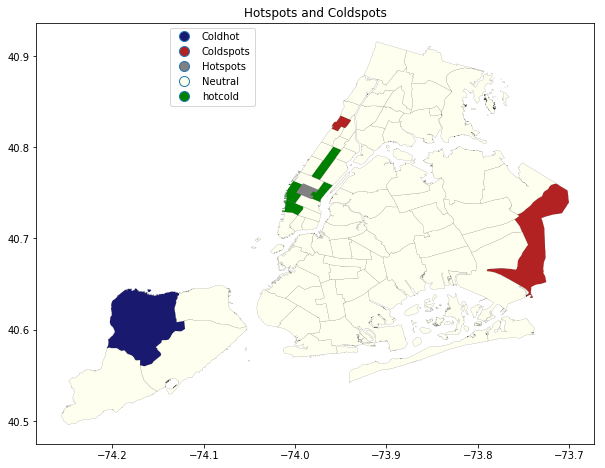

In [105]:

hcmap = matplotlib.colors.ListedColormap(['midnightblue','firebrick','gray','ivory', 'green'])
hotcold = hotspots*1 + coldspots*2 + coldhot*3 + hotcold*4
HotCold_Categories2=[]
for i in range(len(hotcold)):
    if hotcold[i] == 1:
        HotCold_Categories2.append('Hotspots')
    elif hotcold[i] == 2:
        HotCold_Categories2.append('Coldspots')
        
    elif hotcold[i] == 3:
        HotCold_Categories2.append('Coldhot')
    
    elif hotcold[i] == 4:
        HotCold_Categories2.append('hotcold')
    else:
        HotCold_Categories2.append('Neutral')
        
    
label_list = ['N' ,'H' ,'C']
f = pl.figure(figsize(10,10))
ax = merge_counts_gpd.assign(cl=HotCold_Categories2).plot(column='cl', categorical=True, 
        k=2, cmap=hcmap, linewidth=0.1, edgecolor='black',legend=True)

plt.legend(ax=ax,loc = 'upper left')
#ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.2, 0.2, 0.8))

pl.title("Hotspots and Coldspots");
pl.savefig('hcs.png')

hotspots are areas which have a low crime rate in comparision to their neighboring precincts.(Manhattan precinct)
Coldspots are areas which have a low crime rate in comparision to their neighboring precincts.(in this case Queens and a precinct in Manhattan)



hot-cold areas are high crime precincts surrounded by precincts having a low crime rate(Manhattan precints in this case)
cold-hot areas  are low crime areas which has a comparitively higher crime rate in the surrounding districts.

In [115]:
crimes_hl = crimes_post2006[crimes_post2006['OFNS_DESC'] == 'HARRASSMENT 2'][['CMPLNT_NUM','Latitude',
       'Longitude','ADDR_PCT_CD']]


crimes_hl['lonlat'] = list(zip(crimes_hl.Longitude ,crimes_hl.Latitude  ))
crimes_hl['geometry'] = crimes_hl[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [126]:
pp_shp_hl1 = gpd.GeoDataFrame.from_file('./geo_export_c4a19737-82d1-4433-8977-8778832716d0.shp')
pp_shp_hl2 = gpd.GeoDataFrame.from_file('./geo_export_c4a19737-82d1-4433-8977-8778832716d0.shp')

In [127]:
crs = {'init': 'epsg:4326'}

pp_shp_hl1 = gpd.GeoDataFrame(pp_shp_hl1, crs=crs)


pp_shp_hl2 = gpd.GeoDataFrame(pp_shp_hl2, crs=crs)


crs = {'init': 'epsg:4326'}

crimes_hl_gd = gpd.GeoDataFrame(crimes_hl, crs=crs)


In [128]:
crs = {'init': 'epsg:2263'}
crimes_hl_gd_convert = gpd.GeoDataFrame(crimes_hl_gd, crs=crs)

crs = {'init': 'epsg:2263'}
pp_shp_hl1_convert = gpd.GeoDataFrame(pp_shp_hl1, crs=crs)


In [130]:
hl_sjoin = gpd.sjoin(pp_shp_hl1_convert ,crimes_hl_gd_convert)

In [131]:
sum_ct2 = hl_sjoin.groupby('precinct')[['CMPLNT_NUM']].count()

In [133]:
pp_shp_hl2.set_index('precinct', inplace=True)


KeyError: 'precinct'

In [134]:
pl_sjoinm = pp_shp_hl2.merge(sum_ct2,left_index=True, right_index=True)

In [135]:
pl_sjoinm.head()

,shape_area,shape_leng,geometry,CMPLNT_NUM
precinct,,,,
1.0,4.730176e+07,80586.154615,(POLYGON ((-74.0438776157395 40.69018767637665...,399
5.0,1.808880e+07,18676.124259,POLYGON ((-73.98863862848766 40.72293372026369...,234
6.0,2.213214e+07,27175.185625,POLYGON ((-73.99968392160721 40.73855224865976...,201
7.0,1.836402e+07,17301.308682,"POLYGON ((-73.97345389423181 40.718962954076, ...",253
9.0,2.139423e+07,19773.233410,POLYGON ((-73.97160900246391 40.72672340116989...,289


In [144]:
path1='./hl.shp'
pl_sjoinm.to_file(path1)

qW_CT1 = ps.queen_from_shapefile(path1)

Wmatrix, ids = qW_CT1.full()

qW_CT1.transform = 'r'


incidents = pl_sjoinm['CMPLNT_NUM']

incidentsLag = ps.lag_spatial(qW_CT1, incidents)

In [145]:
incidentsLagQ10 = ps.Quantiles(incidentsLag, k=5)
incidentsLagQ10

                Quantiles                 
 
 Lower            Upper              Count
          x[i] <= 312.990               16
312.990 < x[i] <= 386.720               15
386.720 < x[i] <= 484.560               15
484.560 < x[i] <= 598.520               15
598.520 < x[i] <= 823.333               16

In [146]:
I_incidents_hl= ps.Moran(incidents, qW_CT)
I_incidents_hl.I , I_incidents_hl.p_sim

(0.31624476376481747, 0.001)

Once again a high moran's I and a low p-value whereby we reject the null hypothesis that the obervations are randomly distributed.

In [138]:
LMo_Complaints = ps.Moran_Local(incidents.values, qW_CT1 ,permutations=999)

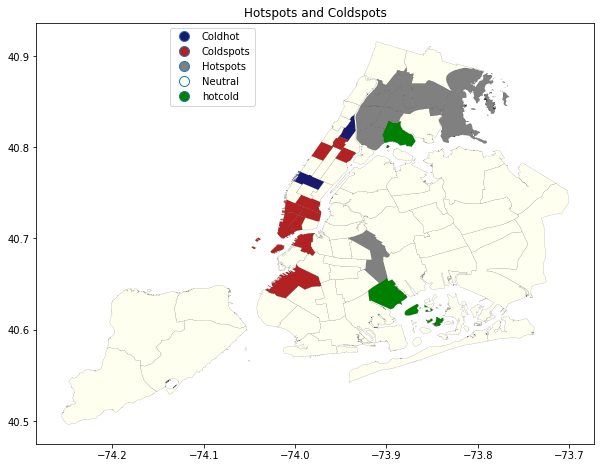

In [139]:
sig = LMo_Complaints.p_sim <= 0.05
hotspots = LMo_Complaints.q==1 * sig
coldspots = LMo_Complaints.q==3 * sig
hotcold = LMo_Complaints.q==2 * sig
coldhot = LMo_Complaints.q==4 * sig


hcmap = matplotlib.colors.ListedColormap(['midnightblue','firebrick','gray','ivory', 'green'])
hotcold = hotspots*1 + coldspots*2 + coldhot*3 + hotcold*4
HotCold_Categories2=[]
for i in range(len(hotcold)):
    if hotcold[i] == 1:
        HotCold_Categories2.append('Hotspots')
    elif hotcold[i] == 2:
        HotCold_Categories2.append('Coldspots')
        
    elif hotcold[i] == 3:
        HotCold_Categories2.append('Coldhot')
    
    elif hotcold[i] == 4:
        HotCold_Categories2.append('hotcold')
    else:
        HotCold_Categories2.append('Neutral')
        
    
label_list = ['N' ,'H' ,'C']
f = pl.figure(figsize(10,10))
ax = pl_sjoinm.assign(cl=HotCold_Categories2).plot(column='cl', categorical=True, 
        k=2, cmap=hcmap, linewidth=0.1, edgecolor='black',legend=True)

plt.legend(ax=ax,loc = 'upper left')
#ax.set_axis_off()
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.2, 0.2, 0.2, 0.8))

pl.title("Hotspots and Coldspots ");
pl.savefig('hcs.png')

Plot showing hotspots, coldspots and spatial outliers of the police precints wrt harrasment cases.